# 13.1 データAPI

## このNotebookの対応するセクションとその概要

- 13.1.4: 1つにまとめる
    - これまで学んだDATA APIを1つにまとめてコードの再利用性を高める
        - `csv_reader_dataset()` 関数を作成
- 13.1.5: プリフェッチ
    - trainingの時間を短縮化するためのテクニック
- 13.1.6: tf.kerasのもとでのデータセットの使い方
    - データAPIを利用した `csv_reader_dataset()`関数をtf.kerasで適用してみる
    - データAPIを利用することで、これまでよりコードをより簡潔にかくことができるようになる
        - つまりこれまでのコードの書き方と少し異なるのでそれについて学ぶ。

### Note

- 13.1では、`CSV`形式を取り扱っていることを必ず忘れないようにしよう。
- 13.2でもっと効率的なデータ形式 `TRRecord` 形式を学ぶ

## 事前準備 (前回の復習)

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    %pip install -q -U tfx
    print("You can safely ignore the package incompatibility errors.")

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### Split the California dataset to multiple CSV files

まず、California housing datasetのロードと準備から始めましょう。まずロードして、トレーニングセット、検証セット、テストセットに分割し、最後にスケーリングします。

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# データセットの読み込み
housing = fetch_california_housing()

# 学習用とテスト用に分ける
X_train_full, X_test, y_train_full, y_test = train_test_split(
                                                housing.data, 
                                                housing.target.reshape(-1, 1), 
                                                random_state=42)

# 先程つくた学習用データセットをさらに学習用と検証用に分ける
X_train, X_valid, y_train, y_valid = train_test_split(
                                        X_train_full, 
                                        y_train_full, 
                                        random_state=42)

# データの標準化
scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_   # 平均
X_std = scaler.scale_   # 標準偏差

メモリに収まらないような非常に大きなデータセットの場合、通常はまず多くのファイルに分割し、TensorFlowにこれらのファイルを並行して読み込ませることになるでしょう。このことを示すために、まず住宅データセットを分割し、20個のCSVファイルに保存してみましょう。

ファイル分割して保存する関数の作成

In [3]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    # ディレクトリ作成
    os.makedirs(housing_dir, exist_ok=True)
    # PATH & ファイル名
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        # "my_{}_{:02d}.csv" に値が渡される
        part_csv = path_format.format(name_prefix, file_idx)
        # path information
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            # 大きく分割した中に存在するIDのループ
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

作成した関数の実行

In [4]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

では、そのCSVファイルの最初の数行を覗いてみましょう。

In [5]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


- `list_files()`メソッドを使うことでfile pathがシャフルされる
- `seed` を指定しない場合はコールするたびにシャフルされる内容が変わる

In [6]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)
for filename in filepath_dataset:
    print(filename)

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_13.csv', shape=(), dtype=string)


2022-10-02 16:41:50.210534: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-02 16:41:50.210650: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
! cat datasets/housing/my_train_15.csv | head -5

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
4.7361,7.0,7.464968152866242,1.1178343949044587,846.0,2.694267515923567,34.49,-117.27,1.745
8.944,30.0,7.170454545454546,1.0875,1776.0,2.018181818181818,34.1,-118.39,5.00001
3.0568,41.0,5.95320197044335,1.0714285714285714,973.0,2.396551724137931,35.38,-118.96,0.856
3.2569,15.0,5.444444444444445,1.08994708994709,891.0,2.357142857142857,36.84,-119.77,1.244


複数ファイルのインターリーブ

In [8]:
n_readers = 5  # 同時5個からファイル読み出し
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

前処理関数の作成

In [9]:
n_inputs = 8 # X_train.shape[-1]

@tf.function
def preprocess(line):
    # csvの各行のデフォルト値を定義する
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    # ここでparseする
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

## 13.1.4 ひとつにまとめる

### ひとつにまとめた関数を作成

In [10]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    # ファイルパスのリストをシャフルして出力
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    # この例だとファイル数は5で中のデータをインターリーブする
    # <Input>
    # - File1: a1, a2, a3 ...
    # - File2: b1, b2, b3 ...
    # - File3: c1, c2, c3 ...
    # - File4: d1, d2, d3 ...
    # - File5: e1, e2, e3 ...
    # <output>
    # - a1, b1, c1, d1, e1, a2, b2, c2, d2, e2, a3, b3, c3, d3, e3,.... 
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    # shuffle_buffer_size で再度シャフル
    dataset = dataset.shuffle(shuffle_buffer_size)
    # 要素１つずつに前処理を施す
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    # batch化する
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

### 関数の動作確認

変数の確認

In [11]:
train_filepaths[:5]

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv']

関数の動作テスト.確認テストのため`batch_size=3`と少なめにした

In [12]:
tf.random.set_seed(42)
train_set = csv_reader_dataset(train_filepaths, batch_size=3)

In [13]:
# 2データ分を試しに出力
for i, (X_batch, y_batch) in enumerate(train_set.take(2)):
    print(f"--------- {i} -----------")
    print("X =", X_batch)
    print("y =", y_batch)
    print()

--------- 0 -----------
X = tf.Tensor(
[[ 0.5804519  -0.20762321  0.05616303 -0.15191229  0.01343246  0.00604472
   1.2525111  -1.3671792 ]
 [ 5.818099    1.8491895   1.1784915   0.28173092 -1.2496178  -0.3571987
   0.7231292  -1.0023477 ]
 [-0.9253566   0.5834586  -0.7807257  -0.28213993 -0.36530012  0.27389365
  -0.76194876  0.72684526]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.752]
 [1.313]
 [1.535]], shape=(3, 1), dtype=float32)

--------- 1 -----------
X = tf.Tensor(
[[-0.8324941   0.6625668  -0.20741376 -0.18699841 -0.14536144  0.09635526
   0.9807942  -0.67250353]
 [-0.62183803  0.5834586  -0.19862501 -0.3500319  -1.1437552  -0.3363751
   1.107282   -0.8674123 ]
 [ 0.8683102   0.02970133  0.3427381  -0.29872298  0.7124906   0.28026953
  -0.72915536  0.86178064]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.919]
 [1.028]
 [2.182]], shape=(3, 1), dtype=float32)



2022-10-02 17:26:46.685021: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## 13.1.5 プリフェッチ

### プリフェッチのコード

- 上記のコードを抜き出すと以下の`dataset.prefetch(1)`がプリフェッチのコードである。
- `n_parse_threads` も重要

```python
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):

    ~~~~ (省略) ~~~~
    
    return dataset.prefetch(1)
```

![prefetch](./13.1.5_prefetch.drawio.svg)

## 13.1.6 tf.kerasのもとでのデータセットの使い方

- california_housing のデータを使って実際に学習、推論を行ってみる
- 先程作成した　`csv_reader_dataset()` が、学習だけでなく検証, テスト用でも使えることを示す
- 従来と引数の指定方法が若干異なることを理解する

### 学習用だけでなく、検証, テスト用データにも前処理を行う

- 先程作った関数を利用して前処理を実行する
- 学習用だけでなく検証用とテスト用のデータもこの関数で作成可能

In [14]:
# repeat=Noneで永遠に繰り返す。
# repeat=Noneもしくはrepeat=10以上(今回のエポック数)にしないとうまく学習できないことに注意
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [15]:
icount = 0
for tmp in train_set.take(2):
    print(tmp)

(<tf.Tensor: shape=(32, 8), dtype=float32, numpy=
array([[ 1.18324661e+00, -2.86731392e-01,  2.56954998e-01,
        -9.14653018e-02,  6.74161077e-01,  5.36658242e-02,
        -7.43209183e-01,  7.11849034e-01],
       [-4.45226371e-01,  1.84918952e+00, -3.20666254e-01,
        -1.40449286e-01, -1.06119268e-01, -6.69142455e-02,
        -6.91677988e-01,  7.31840193e-01],
       [ 3.09196889e-01,  5.04350424e-01,  2.08594278e-01,
        -2.77027190e-01,  6.08453274e-01,  2.73698270e-01,
        -8.46275151e-01,  7.81819880e-01],
       [-1.28795540e+00,  1.45364857e+00, -5.05224824e-01,
         2.03960374e-01, -4.95803148e-01,  4.35151726e-01,
        -7.66634524e-01,  6.56878173e-01],
       [-6.46088064e-01, -1.07781315e+00, -3.59055459e-01,
         9.48920622e-02,  1.03099108e+00, -2.29778379e-01,
        -7.24471331e-01,  9.76728678e-01],
       [ 1.76200092e+00, -6.82272315e-01,  7.48218775e-01,
        -2.33296052e-01, -6.32694423e-01, -3.28950375e-01,
        -1.32412410e+00,  1

### 次にSequential API を使ってNeuralNetモデルを作成する

このステップは従来どおりである

![](https://docs.google.com/drawings/d/e/2PACX-1vSiIQ399T-rsCxEeqT4aD1vTE7YFMjmQRXDfz-4T3PmWcFAl_RYkyeyKzwozmJAFWfMrH949cPjMCN-/pub?w=583&h=402)

In [16]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [17]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                270       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


### 学習の開始

In [20]:
batch_size = 32
num_epochs = 10

#### 従来方法 (10.2.3 参照)

- 従来方法は、引数に `X_train, y_train`, `validation_data=(X_varid, y_valid)` と値を渡している
- 今回はデータとラベルが１つにまとまっている

従来の前処理は以下

```python
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
```

モデル作成方法は今回と同様で、学習開始の`fit()`メソッドおける引数の渡し方が従来方法と異なる

```python
history = model.fit(X_train, y_train,
                    epochs=num_epochs, 
                    validation_data=(X_valid, y_valid))
```

#### 本章で作成したデータセットを使った学習

In [21]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
res = model.fit(train_set,                                           # 学習データ
                steps_per_epoch=(len(X_train) // batch_size),    # エポックあたり、なんステップあるか？
                epochs=num_epochs,                               # エポック数
                validation_data=valid_set)                       # 検証用データ

Epoch 1/10
 17/362 [>.............................] - ETA: 1s - loss: 4.9388  

2022-10-02 17:38:27.081323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


360/362 [============================>.] - ETA: 0s - loss: 2.3133

2022-10-02 17:38:28.210116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


362/362 [==============================] - 2s 4ms/step - loss: 2.3069 - val_loss: 0.9083
Epoch 2/10
362/362 [==============================] - 1s 3ms/step - loss: 0.7222 - val_loss: 0.6887
Epoch 3/10
362/362 [==============================] - 1s 4ms/step - loss: 0.6173 - val_loss: 0.6139
Epoch 4/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5631 - val_loss: 0.5646
Epoch 5/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5647 - val_loss: 0.5061
Epoch 6/10
362/362 [==============================] - 1s 3ms/step - loss: 0.4986 - val_loss: 0.5157
Epoch 7/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5014 - val_loss: 0.4664
Epoch 8/10
362/362 [==============================] - 1s 3ms/step - loss: 0.4725 - val_loss: 0.4468
Epoch 9/10
362/362 [==============================] - 1s 3ms/step - loss: 0.4710 - val_loss: 0.4398
Epoch 10/10
362/362 [==============================] - 1s 3ms/step - loss: 0.4618 - val_loss: 0.4285


In [22]:
res.history.keys()

dict_keys(['loss', 'val_loss'])

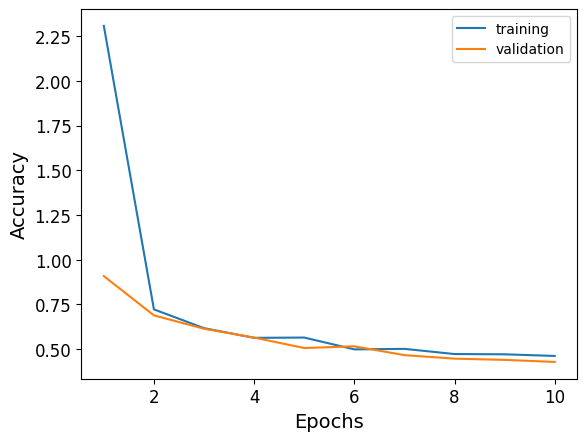

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(1, num_epochs+1), res.history['loss'], label="training")
plt.plot(range(1, num_epochs+1), res.history['val_loss'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### この前処理したデータは`evaluate()`, `predict()` でも使うことができる

#### 学習モデルの評価

In [24]:
# "//" であまりは無視
res = model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 2ms/step - loss: 0.4432


#### 推論時はラベル情報はいらない。もしラベル情報を削除したいなら以下のように処理する

In [25]:
new_set = test_set.map(lambda X, y: X) 
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

124/161 [======================>.......] - ETA: 0s

2022-10-02 17:38:57.703305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - 0s 1ms/step


array([[3.9054303],
       [2.515842 ],
       [1.1908185],
       ...,
       [3.3227916],
       [1.3247879],
       [3.2831535]], dtype=float32)

#### Kerasはラベルを無視することができる。めんどくさければそのままでもOK

In [26]:
model.predict(test_set, steps=len(X_new) // batch_size)

124/161 [======================>.......] - ETA: 0s

2022-10-02 17:39:01.140545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - 0s 1ms/step


array([[1.5967462 ],
       [3.1248822 ],
       [3.4969707 ],
       ...,
       [2.9878387 ],
       [1.5033703 ],
       [0.99150753]], dtype=float32)

### 独自ループを作りたい場合、ごく自然に訓練セットを反復処理できる (12.3.9 参照)

#### 12.3.9 のコード 抜粋

```python
# エポックのループ
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    # バッチのループ
    for step in range(1, n_steps + 1):
        # 適当にバッチサイズを取得, デフォルトは32に設定
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            # 順伝搬
            y_pred = model(X_batch)
            # lossの計算, reduce_meanでバッチ毎の平均ロスを計算
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            # メインのロスの他に、レイヤ毎の正則化ロスを加えている
            loss = tf.add_n([main_loss] + model.losses)
        # 逆伝搬の計算
        gradients = tape.gradient(loss, model.trainable_variables)
        # オプティマイザー従って重みなど値を更新する
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
```

#### 13.1.6のコード

- ループ処理の工程が簡単にかけるようになっていることに注目する
- ちゃんと学習工程を動かすには、12.3.9のコードを参照して付け加えること

In [27]:
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0
for X_batch, y_batch in train_set.take(total_steps):                          # ここが異なる
    global_step += 1                                                          # ここが異なる
    print("\rGlobal step {}/{}".format(global_step, total_steps), end="")
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 1810/1810

### 訓練ループ全体を実行するTF関数にも対応可能

- Python関数からTF関数に変換することで、計算グラフが最適化され、高速に計算することができる
- 以下のコードは、前処理も含めて`@tf.function`のデコレータを用い、tf関数化されている。データAPIはtf関数化をサポートしていることを知っていればOK
- 以下、なぜ２つのTF関数が紹介されているかはよくわからない。２つ目のコードのほうを見ればよいと思う。そちらはちゃんと学習の動作をする

In [28]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
# こっちではなく、次のコードを参照したほうが参考になる
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

2022-10-02 17:40:53.018745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:40:53.056207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:40:53.091515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [30]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    n_steps_per_epoch = len(X_train) // batch_size                      # 追加
    total_steps = n_epochs * n_steps_per_epoch                          # 追加
    global_step = 0                                                     # 追加
    for X_batch, y_batch in train_set.take(total_steps):                # 変更
        global_step += 1                                                # 追加
        if tf.equal(global_step % 100, 0):                              # 追加
            tf.print("\rGlobal step", global_step, "/", total_steps)    # 追加
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

2022-10-02 17:41:03.966944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:41:04.007108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-02 17:41:04.044925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Global step 100 / 1810
Global step 200 / 1810
Global step 300 / 1810
Global step 400 / 1810
Global step 500 / 1810
Global step 600 / 1810
Global step 700 / 1810
Global step 800 / 1810
Global step 900 / 1810
Global step 1000 / 1810
Global step 1100 / 1810
Global step 1200 / 1810
Global step 1300 / 1810
Global step 1400 / 1810
Global step 1500 / 1810
Global step 1600 / 1810
Global step 1700 / 1810
Global step 1800 / 1810


## 以下 `Dataset` クラスの各メソッドの簡単な説明

- 以下のコードは便利かも。いろいろ使えそう

In [32]:
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):         # __doc__というメソッドがTrueならば
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● choose_from_datasets()Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Create

## 補足

### 演算子 `//` の挙動

In [39]:
batch_size = 32
print(len(X_train) / batch_size)
print(len(X_train) // batch_size)
print(int(len(X_train) / batch_size))

362.8125
362
362


### `getattr`

In [40]:
class hello():
    def __init__(self):
        self.x = 1
        self.y = 2
    def plus(self):
        return self.x + self.y
    def minus(self):
        return self.y - self.x
    def args(self, s):
        return "I got {}".format(s)

test = hello() 
print(getattr(test, "x"))
print(getattr(test, "plus")())
print(getattr(test, "minus")())
print(getattr(test, "multi", "None"))
print(getattr(test, "args")("Hello World"))

1
3
1
None
I got Hello World


### `hasattr`

In [41]:
class AttrTest():
 
    def __init__(self):
        self.code = -1
 
 
test = AttrTest()
test.name = 'python-izm'
 
print(hasattr(test, 'code'))
print(hasattr(test, 'name'))
print(hasattr(test, 'kana'))

True
True
False


## 参考

- https://qiita.com/typecprint/items/3d10e77e76e74db6e9e9

## メモ

- `repeat()`メソッドの使い所がよくわからない
- TF関数の使い所。Pythonコードは高速化のためにとりあえず変換しちゃえば良い？
    - ルールはあるので注意